In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
np.random.seed(42)  # For reproducible results

print("Setup complete!")


Setup complete!


In [23]:
# Physical and simulation parameters
alpha = 0.1      # Radial interaction strength
beta = 0.01    # Repulsion strength
R0 = 0.5         # Minimum separation distance (bot radius)
f0 = 0.2       # Tangential interaction strength
dt = 0.05       # Time step for integration
T = 100       # Total simulation time
Nt = int(T / dt) # Number of time steps

# Bot parameters
N_BOTS = 20
BOT_RADIUS = 0.2  # Visual radius for plotting

# Spinning rates
omega_fast = 4 # High spinning rate
omega_slow = 1   # Low spinning rate

# Define which bots are fast (indices)
fast_bot_indices = [1]  # Bots 2, 5, and 8 (0-indexed)

print(f"Simulation setup:")
print(f"Number of bots: {N_BOTS}")
print(f"Fast spinning bots (indices): {fast_bot_indices}")
print(f"Fast spinning rate: {omega_fast} rad/s")
print(f"Slow spinning rate: {omega_slow} rad/s")
print(f"Simulation time: {T} seconds")
print(f"Time steps: {Nt}")


Simulation setup:
Number of bots: 20
Fast spinning bots (indices): [1]
Fast spinning rate: 4 rad/s
Slow spinning rate: 1 rad/s
Simulation time: 100 seconds
Time steps: 2000


In [24]:
# Create initial positions in a circular arrangement
angles = np.linspace(0, 2*np.pi, N_BOTS, endpoint=False)
initial_radius = 4
noise_scale = 0.00001

# Generate initial positions with some random perturbation
X0 = np.zeros(2 * N_BOTS)  # [x1, y1, x2, y2, ..., x10, y10]

for i in range(N_BOTS):
    x = initial_radius * np.cos(angles[i]) + noise_scale * (np.random.random() - 0.5)
    y = initial_radius * np.sin(angles[i]) + noise_scale * (np.random.random() - 0.5)
    X0[2*i] = x      # x coordinate
    X0[2*i + 1] = y  # y coordinate

# Set up control signals (spinning rates)
U_full = np.zeros((Nt, N_BOTS))
for t in range(Nt):
    for i in range(N_BOTS):
        if i in fast_bot_indices:
            U_full[t, i] = omega_fast
        else:
            U_full[t, i] = omega_slow

print(f"Initial configuration created with {N_BOTS} bots")
print(f"Initial positions shape: {X0.shape}")
print(f"Control signals shape: {U_full.shape}")


Initial configuration created with 20 bots
Initial positions shape: (40,)
Control signals shape: (2000, 20)


In [25]:
def compute_forces(X, u, epsilon=1e-3):
    """
    Compute forces acting on each bot due to interactions with other bots.
    """
    pos = X.reshape(N_BOTS, 2)  # Reshape to (N_BOTS, 2) for easier indexing
    forces = np.zeros_like(pos)
    
    for i in range(N_BOTS):
        for j in range(N_BOTS):
            if i == j:
                continue
                
            # Vector from bot i to bot j
            rij = pos[j] - pos[i]
            dist = np.linalg.norm(rij) + epsilon  # Add small epsilon to avoid division by zero
            
            # Unit vector in radial direction
            rhat = rij / dist
            
            # Radial force (attraction/repulsion)
            Fr = (alpha * u[i]) / dist - beta / ((dist - R0)**6 + epsilon)
            
            # Tangential force (perpendicular to radial direction)
            perp = np.array([-rhat[1], rhat[0]])
            Ft = (f0 * u[i]) / dist
            
            # Total force from bot j on bot i
            forces[i] += Fr * rhat + Ft * perp
    
    return forces.reshape(-1)  # Flatten back to 1D array

def rk4_step(X, u):
    """Fourth-order Runge-Kutta integration step."""
    k1 = compute_forces(X, u)
    k2 = compute_forces(X + 0.5 * dt * k1, u)
    k3 = compute_forces(X + 0.5 * dt * k2, u)
    k4 = compute_forces(X + dt * k3, u)
    
    return X + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

print("Physics functions defined!")


Physics functions defined!


In [26]:
# Run the simulation
print("Starting simulation...")
start_time = time.time()

X = X0.copy()
trajectory = [X.reshape(N_BOTS, 2).copy()]

for t in range(Nt):
    if t % 100 == 0:  # Progress indicator
        progress = (t / Nt) * 100
        print(f"Progress: {progress:.1f}%")
    
    u = U_full[t]
    X = rk4_step(X, u)
    trajectory.append(X.reshape(N_BOTS, 2).copy())

trajectory = np.array(trajectory)  # Shape: (Nt+1, N_BOTS, 2)
time_vec = np.linspace(0, T, Nt + 1)

end_time = time.time()
print(f"Simulation completed in {end_time - start_time:.2f} seconds")
print(f"Trajectory shape: {trajectory.shape}")


Starting simulation...
Progress: 0.0%
Progress: 5.0%
Progress: 10.0%
Progress: 15.0%
Progress: 20.0%
Progress: 25.0%
Progress: 30.0%
Progress: 35.0%
Progress: 40.0%
Progress: 45.0%
Progress: 50.0%
Progress: 55.0%
Progress: 60.0%
Progress: 65.0%
Progress: 70.0%
Progress: 75.0%
Progress: 80.0%
Progress: 85.0%
Progress: 90.0%
Progress: 95.0%
Simulation completed in 13.32 seconds
Trajectory shape: (2001, 20, 2)


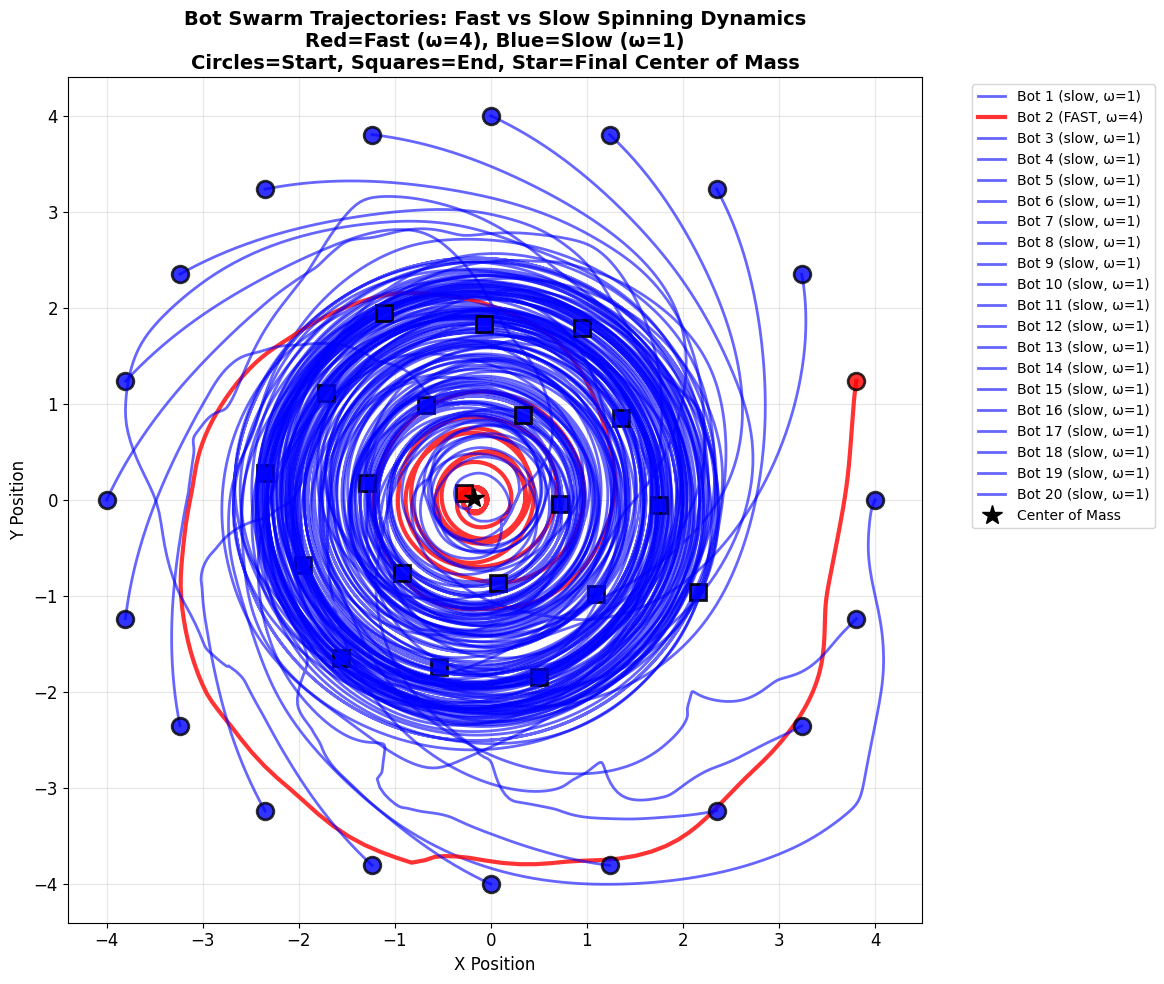

🎯 Simulation Complete!
📊 Trajectory data: (2001, 20, 2)
🕐 Simulated 100 seconds with 2001 time points
🤖 20 bots (1 fast, 19 slow)
📍 Final center of mass: (-0.18, 0.02)


In [27]:
# Calculate final positions and center of mass
final_positions = trajectory[-1]
center_of_mass = np.mean(final_positions, axis=0)

# Create trajectory visualization
fig, ax = plt.subplots(figsize=(12, 10))

# Plot trajectories with different colors for fast vs slow bots
for i in range(N_BOTS):
    if i in fast_bot_indices:
        color = 'red'
        linewidth = 3.0
        alpha = 0.8
        label = f'Bot {i+1} (FAST, ω={omega_fast})'
    else:
        color = 'blue'
        linewidth = 2.0
        alpha = 0.6
        label = f'Bot {i+1} (slow, ω={omega_slow})'
    
    # Plot trajectory
    ax.plot(trajectory[:, i, 0], trajectory[:, i, 1], 
            color=color, linewidth=linewidth, alpha=alpha, label=label)
    
    # Mark starting positions with circles
    ax.plot(trajectory[0, i, 0], trajectory[0, i, 1], 'o', 
            color=color, markersize=12, alpha=0.8, markeredgecolor='black', markeredgewidth=2)
    
    # Mark ending positions with squares
    ax.plot(trajectory[-1, i, 0], trajectory[-1, i, 1], 's', 
            color=color, markersize=12, alpha=0.9, markeredgecolor='black', markeredgewidth=2)

# Mark center of mass
ax.plot(center_of_mass[0], center_of_mass[1], 'k*', markersize=15, label='Center of Mass')

ax.set_aspect('equal')
ax.set_title(f"Bot Swarm Trajectories: Fast vs Slow Spinning Dynamics\n"
             f"Red=Fast (ω={omega_fast}), Blue=Slow (ω={omega_slow})\n"
             f"Circles=Start, Squares=End, Star=Final Center of Mass", 
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlabel('X Position', fontsize=12)
ax.set_ylabel('Y Position', fontsize=12)

plt.tight_layout()
plt.show()

print("🎯 Simulation Complete!")
print(f"📊 Trajectory data: {trajectory.shape}")
print(f"🕐 Simulated {T} seconds with {len(trajectory)} time points")
print(f"🤖 {N_BOTS} bots ({len(fast_bot_indices)} fast, {N_BOTS-len(fast_bot_indices)} slow)")
print(f"📍 Final center of mass: ({center_of_mass[0]:.2f}, {center_of_mass[1]:.2f})")


🎬 Starting animation creation...
Creating animation with 2001 frames...
Creating 667 animation frames...
Animation progress: 0.0%
Animation progress: 0.0%
Saving animation to bot_swarm_evolution.mp4...
Animation progress: 0.0%
Animation progress: 0.0%
Animation progress: 7.5%
Animation progress: 15.0%
Animation progress: 22.5%
Animation progress: 30.0%
Animation progress: 37.5%
Animation progress: 45.0%
Animation progress: 52.5%
Animation progress: 60.0%
Animation progress: 67.5%
Animation progress: 75.0%
Animation progress: 82.5%
Animation progress: 90.0%
Animation progress: 97.5%
✅ Animation saved successfully using ffmpeg!
📁 File: bot_swarm_evolution.mp4
🎬 Duration: ~66.7 seconds at 10 FPS


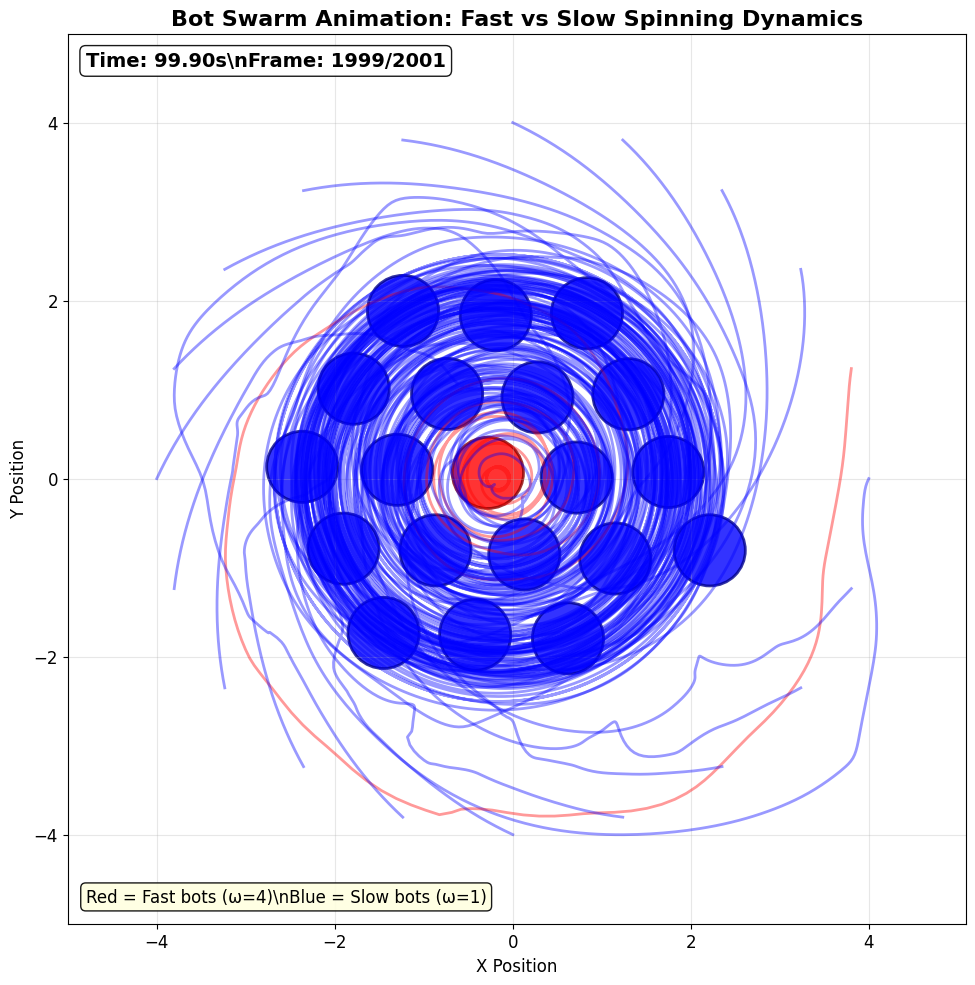

🎉 Animation process complete!


In [ ]:
# Create and save animation as MP4
import matplotlib.animation as animation
from matplotlib.patches import Circle

def create_animation_mp4(trajectory, time_vec, filename='bot_swarm_animation.mp4', skip_frames=5):
    """
    Create and save an animated visualization of the bot swarm as MP4.
    """
    print(f"Creating animation with {len(trajectory)} frames...")
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Set up the plot boundaries
    x_range = [trajectory[:,:,0].min() - 1, trajectory[:,:,0].max() + 1]
    y_range = [trajectory[:,:,1].min() - 1, trajectory[:,:,1].max() + 1]
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title('Bot Swarm Animation: Fast vs Slow Spinning Dynamics', fontsize=16, fontweight='bold')
    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Y Position', fontsize=12)
    
    # Initialize bot circles and trajectory lines
    bot_circles = []
    trajectory_lines = []
    
    for i in range(N_BOTS):
        if i in fast_bot_indices:
            color = 'red'
            edge_color = 'darkred'
            bot_label = 'FAST'
        else:
            color = 'blue'
            edge_color = 'darkblue'
            bot_label = 'slow'
        
        # Create bot circle (representing the physical bot)
        circle = Circle((trajectory[0, i, 0], trajectory[0, i, 1]), 
                       BOT_RADIUS*2, color=color, alpha=0.8, ec=edge_color, linewidth=2)
        ax.add_patch(circle)
        bot_circles.append(circle)
        
        # Create trajectory line (showing path history)
        line, = ax.plot([], [], color=color, alpha=0.4, linewidth=2)
        trajectory_lines.append(line)
    
    # Time and info text
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=14, 
                       verticalalignment='top', fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    info_text = ax.text(0.02, 0.02, f'Red = Fast bots (ω={omega_fast})\\nBlue = Slow bots (ω={omega_slow})', 
                       transform=ax.transAxes, fontsize=12, verticalalignment='bottom',
                       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    def animate(frame):
        actual_frame = frame * skip_frames
        if actual_frame >= len(trajectory):
            actual_frame = len(trajectory) - 1
            
        # Update bot positions
        for i in range(N_BOTS):
            # Move the bot circle to new position
            bot_circles[i].center = (trajectory[actual_frame, i, 0], trajectory[actual_frame, i, 1])
            
            # Update trajectory line (show path up to current frame)
            trajectory_lines[i].set_data(trajectory[:actual_frame+1, i, 0], 
                                        trajectory[:actual_frame+1, i, 1])
        
        # Update time display
        current_time = time_vec[actual_frame] if actual_frame < len(time_vec) else time_vec[-1]
        time_text.set_text(f'Time: {current_time:.2f}s\\nFrame: {actual_frame+1}/{len(trajectory)}')
        
        # Progress indicator
        if frame % 50 == 0:
            progress = (frame * skip_frames / len(trajectory)) * 100
            print(f"Animation progress: {progress:.1f}%")
        
        return bot_circles + trajectory_lines + [time_text, info_text]
    
    # Create animation
    frames = len(trajectory) // skip_frames
    print(f"Creating {frames} animation frames...")
    
    anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=True, repeat=True)
    
    # Save as MP4
    print(f"Saving animation to {filename}...")
    try:
        # Try different writers in order of preference
        writers = ['ffmpeg', 'pillow']
        writer_used = None
        
        for writer_name in writers:
            try:
                if writer_name == 'ffmpeg':
                    writer = animation.FFMpegWriter(fps=10, bitrate=1800)
                elif writer_name == 'pillow':
                    writer = animation.PillowWriter(fps=10)
                
                anim.save(filename, writer=writer, dpi=100)
                writer_used = writer_name
                break
            except Exception as e:
                print(f"Writer {writer_name} failed: {e}")
                continue
        
        if writer_used:
            print(f"✅ Animation saved successfully using {writer_used}!")
            print(f"📁 File: {filename}")
            print(f"🎬 Duration: ~{frames/10:.1f} seconds at 10 FPS")
        else:
            print("❌ Could not save animation - no suitable writer found")
            print("Try installing ffmpeg: conda install ffmpeg -c conda-forge")
            
    except Exception as e:
        print(f"❌ Error saving animation: {e}")
        print("💡 Tip: Make sure ffmpeg is installed or try a different format")
    
    plt.tight_layout()
    return fig, anim

# Create and save the animation
print("🎬 Starting animation creation...")
fig_anim, anim = create_animation_mp4(trajectory, time_vec, 'bot_swarm_evolution.mp4', skip_frames=3)

# Also display a static frame as preview
plt.show()
print("🎉 Animation process complete!")
